<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/toy_phrase_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import time
import math

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device:', device)

Using device: cuda


###Toy Data Construction

#### Toy Data Functions

In [ ]:
def generateWordBank(context_words=False, variable_length=False, unordered=False):
  """
  Creates the word bank based on various inputs
  """
  if unordered:
    words = ['red', 'green', 'blue', 'vred', 'vgreen', 'vblue']
  else:
    words = ['awful', 'bad', 'the', 'good', 'awesome']
  
  if context_words:
    words.extend(['not', 'extremely'])
  if variable_length:
    words.append('<EoS>')

  return words

def make_toy_phrase(phrase_length, words, variable_length=False, min_phrase_len=10):
  """
  Creates a single toy phrase
  """

  phrase = []
  n_words = len(words)
  # Sets phrase length, allowing for variable length
  if variable_length:
    length = min_phrase_len + np.random.randint(phrase_length - min_phrase_len)
  else:
    length = phrase_length
  
  for idx in range(length):
    next_word = False
    while not next_word:
      next_word = False
      word_idx = np.random.randint(n_words)
      if words[word_idx] == 'extremely' and idx > 0: # No repeat 'extremely'
        if phrase[idx-1] != 'extremely':
          next_word = True
      elif words[word_idx] == 'not' and idx > 0: # No repeat 'not'
        found_not = False
        for idx2 in range(1, min(4, idx+1)): # up to 4 words back
          if phrase[idx-idx2]== 'not':
            found_not = True
        if not found_not:
          next_word = True
      elif words[word_idx] != '<EoS>':
        next_word = True
    phrase.append(words[word_idx])

  # Adds EoS at end for variable length phrases
  if variable_length:
    phrase.append('<EoS>')
  
  return phrase

def eval_toy_phrase(toy_phrase, max_phrase_length=50, unordered=False):
  """
  Evaluates a single toy phrase and returns a score
  """

  if unordered:
    score = [0, 0, 0]
    base_word_vals = {'red': [1,0,0], 'green': [0,1,0], 'blue': [0,0,1], 
                    'vred': [2,0,0], 'vgreen': [0,2,0], 'vblue': [0,0,2]}
  else:
    score = 0
    base_word_vals = {'awful': -2, 'bad': -1, 'the': 0, 'good': 1, 'awesome': 2}
  phrase_length = len(toy_phrase)
  extreme_length = 0 # range of influence of extreme
  not_length = 0 # range of influence of not

  for idx in range(phrase_length):
    if toy_phrase[idx] in list(base_word_vals.keys()):
      base_score = base_word_vals[toy_phrase[idx]]
      if unordered:
        if not_length > 0: 
          base_score = [-1*x for x in base_score]
        if extreme_length > 0: 
          base_score = [2*x for x in base_score]
        score = [sum(x) for x in zip(score, base_score)]
      else:
        if not_length > 0: 
          base_score = -1 * base_score
        if extreme_length > 0: 
          base_score = 2 * base_score
        score += base_score
      # print('Adding', base_score, 'for', toy_phrase[idx])
    elif toy_phrase[idx] == 'not':
      not_length = 4
    elif toy_phrase[idx] == 'extremely':
      extreme_length = 2
    elif toy_phrase[idx] == '<EoS>': break
    
    if not_length > 0: not_length -= 1 # decays not
    if extreme_length > 0: extreme_length -= 1 # decays extremely
  
  # Normalizes by approximate variance
  score /= np.sqrt(2 * max_phrase_length)

  return score

def wordToIndex(word, word_bank):
  """
  Converts a word into corresponding index in words
  """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """
  For demonstration, turn a letter into a <1 x n_words> Tensor
  """
  n_words = len(word_bank)
  tensor = torch.zeros(1, n_words)
  tensor[0][wordToIndex(word, word_bank)] = 1
  return tensor

def phraseToTensor(phrase, word_bank):
  """
  Turn a phrase into a <phrase_length x 1 x n_words> (an array of one-hot letter vectors)
  """
  n_words = len(word_bank)
  tensor = torch.zeros(len(phrase), 1, n_words)
  for wi, word in enumerate(phrase):
      tensor[wi][0][wordToIndex(word, word_bank)] = 1
  return tensor

def classifySentiment(score, sentiments, loss_type='XE', unordered=False):
  """
  Turns a score of a toy phrase into a sentiment
  Contains definitions of thresholds for dividing into multiple classes
  """
  n_sentiments = len(sentiments)

  if unordered:
    if np.argmax(score) == 0:
      sentiment = 'Red'
    elif np.argmax(score) == 1:
      sentiment = 'Green'
    else:
      sentiment = 'Blue'
  else:
    # Used for 3-class sentiment analysis, about 1/3 will be neutral
    neutral_thresh = 0.43

    # 5-class sentiment analysis, about 1/5 will be of each class
    three_star_thresh = 0.253
    four_star_thresh = 0.843

    if n_sentiments == 2:
      if loss_type == 'XE':
        if score >= 0:
          sentiment = 'Good'
        else:
          sentiment = 'Bad'
        sentiment_tensor = torch.tensor([sentiments.index(sentiment)], dtype=torch.long)
      elif loss_type == 'MSE':
        sentiment = score
        sentiment_tensor = torch.tensor([score], dtype=torch.float).view(1, -1)
    elif n_sentiments == 3:
      if score >= neutral_thresh:
        sentiment = 'Good'
      elif score <= -1 * neutral_thresh:
        sentiment = 'Bad'
      else:
        sentiment = 'Neutral'
    elif n_sentiments == 5:
      if score > four_star_thresh:
        sentiment = 'Five'
      elif score > three_star_thresh:
        sentiment = 'Four'
      elif score > -1 * three_star_thresh:
        sentiment = 'Three'
      elif score > -1 * four_star_thresh:
        sentiment = 'Two'
      else:
        sentiment = 'One'

  return sentiment

def randomTrainingExample(example_specs):
  """
  Generates a random training example consisting of phrase and sentiment and corresponding tensors
  """
  # Unpacks example_specs (with defaults)
  phrase_length = example_specs['phrase_length']
  words = example_specs['words']
  sentiments = example_specs['sentiments']
  loss_type = example_specs['loss_type'] if 'loss_type' in example_specs else 'XE'
  variable_length = example_specs['variable_length'] if 'variable_length' in example_specs else 'False'
  min_phrase_len = example_specs['min_phrase_len'] if 'min_phrase_len' in example_specs else 10
  unordered_class = example_specs['unordered_class'] if 'unordered_class' in example_specs else 'False'

  phrase = make_toy_phrase(phrase_length, words, variable_length=variable_length, min_phrase_len=min_phrase_len)
  score = eval_toy_phrase(phrase, max_phrase_length=phrase_length, unordered=unordered_class)
  
  sentiment = classifySentiment(score, sentiments, loss_type, unordered=unordered_class)

  sentiment_tensor = torch.tensor([sentiments.index(sentiment)], dtype=torch.long)
  phrase_tensor = phraseToTensor(phrase, words)
  
  return sentiment, phrase, sentiment_tensor, phrase_tensor

#### Toy Data Tests

In [ ]:
# Various tests/confirmations of phrase generation
phrase_length = 50

# Use an unordered class set (red, green, blue)
unordered_class = True

context_words = True
variable_length = False # Takes max phrase length as phrase length
min_phrase_len = 10

words = generateWordBank(context_words=context_words, variable_length=variable_length, unordered=unordered_class)
# sentiments = ['One', 'Two', 'Three', 'Four', 'Five']
sentiments = ['Red', 'Green', 'Blue']

# Dictionary which holds all the specifications for generating training examples
example_specs = {'phrase_length': phrase_length, 'words': words, 'sentiments':sentiments, 'loss_type':'XE', 
                 'variable_length': variable_length, 'min_phrase_len': min_phrase_len, 'unordered_class': unordered_class}

# Makes five phrases and reports socres
print('Five phrases and scores:')
for i in range(5):
  toy_phrase = make_toy_phrase(phrase_length, words)
  print(toy_phrase)
  score = eval_toy_phrase(toy_phrase, unordered=unordered_class)
  print(score)

# Makes many phrases and evaluates scores to see distribution
trials = 10000
scores = []
lengths = []
for trial in range(trials):
  toy_phrase = make_toy_phrase(phrase_length, words)
  lengths.append(len(toy_phrase))
  score = eval_toy_phrase(toy_phrase, unordered=unordered_class)
  scores.append(score)

if not unordered_class:
  print('Variance:', np.var(scores))

  # Histogram of scores
  plt.hist(scores, bins=40)
  plt.show()

if variable_length:
  # Histogram of lengths
  plt.hist(lengths, bins=len(set(lengths)))
  plt.show()

# Tensor conversion of toy phrases
toy_phrase = make_toy_phrase(12, words)
print('Toy phrase:', toy_phrase)
print('Toy phrase score:', eval_toy_phrase(toy_phrase, unordered=unordered_class))
print('Tensor for phrase:', phraseToTensor(toy_phrase, words))

# Random generation of training examples
for i in range(4):
    sentiment, phrase, sentiment_tensor, phrase_tensor = randomTrainingExample(example_specs)
    print('sentiment =', sentiment, '/ phrase =', phrase)
    print('sentiment tensor =', sentiment_tensor)

# Checks sentiment count
count = np.zeros(len(sentiments))
for i in range(10000):
  _, _, sentiment_tensor, _ = randomTrainingExample(example_specs)
  count[sentiment_tensor.numpy()[0]] += 1
print('Percentage of sentiments:', count/10000)

Five phrases and scores:
['not', 'green', 'blue', 'blue', 'vblue', 'blue', 'red', 'blue', 'not', 'vgreen', 'vblue', 'vred', 'not', 'vgreen', 'extremely', 'vgreen', 'extremely', 'green', 'vblue', 'red', 'blue', 'extremely', 'blue', 'extremely', 'red', 'blue', 'vblue', 'extremely', 'vgreen', 'blue', 'vblue', 'vgreen', 'extremely', 'vblue', 'not', 'vred', 'vblue', 'vred', 'extremely', 'blue', 'green', 'green', 'vblue', 'vgreen', 'red', 'red', 'vgreen', 'green', 'extremely', 'blue']
[0.  0.6 1.9]
['blue', 'vred', 'vblue', 'not', 'green', 'red', 'green', 'red', 'green', 'vblue', 'vred', 'extremely', 'vred', 'red', 'green', 'vblue', 'extremely', 'red', 'vgreen', 'not', 'red', 'red', 'green', 'vblue', 'not', 'extremely', 'blue', 'extremely', 'vgreen', 'vred', 'extremely', 'red', 'blue', 'vgreen', 'vred', 'not', 'green', 'extremely', 'vred', 'vblue', 'green', 'extremely', 'red', 'extremely', 'not', 'red', 'green', 'green', 'not', 'extremely']
[1.2 0.5 1. ]
['blue', 'extremely', 'blue', 'blue',

###Network

#### Network Definitions/Functions

In [ ]:
class VanillaRNN(nn.Module):
    """
    Vanilla RNN
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        if binary:
          self.i2o = nn.Linear(input_size + hidden_size, 1)
        else:
          self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        if binary and loss_type == 'XE': # Converts single output into two
          output = torch.stack([-1/2 * output.view(1), 1/2 * output.view(1)], dim=1)
        # output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class GruRNN(nn.Module):
    """
    GRU with readout layer 
    """
    def __init__(self, input_size, hidden_size, output_size, ro_bias=True):
        super(GruRNN, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        if binary:
          self.o2o = nn.Linear(hidden_size, 1, bias=ro_bias)
        else:
          self.o2o = nn.Linear(hidden_size, output_size, bias=ro_bias)
        # self.softmax = nn.LogSoftmax(dim=1)

        if not ro_bias: print('No readout bias.')

    def forward(self, input, hidden):
        input = input.view(1, 1, -1)
        hidden = hidden.view(1, 1, -1)
        output, hidden = self.gru(input, hidden)
        output = self.o2o(output[0])
        if binary and loss_type == 'XE': # Converts single output into two
          output = torch.stack([-1/2 * output.view(1), 1/2 * output.view(1)], dim=1)
        # output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class autoRegTransformer(nn.Module):
    """
    Bare attention with readout layer 
    """
    def __init__(self, input_size, hidden_size, output_size, ro_bias=True):
        super(bareAttnRNN, self).__init__()

        self.hidden_size = hidden_size
        self.query_layer = nn.Linear(input_size, hidden_size) # F x D
        self.key_layer = nn.Linear(input_size, hidden_size) # F x D
        
        self.value_layer = nn.Linear(input_size, input_size) # F x F

        self.read_out = nn.Linear(input_size, output_size, bias=ro_bias)

        if not ro_bias: print('No readout bias.')

    def forward(self, input, hidden):
        
        query = self.query_layer(input)
        key = self.key_layer(input)
        value = self.value_layer(input)

        query_k = self.kenr_fn(query)
        key_k = self.kenr_fn(key)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class bareAttnRNN(nn.Module):
    """
    Bare attention with readout layer 
    """
    def __init__(self, input_size, hidden_size, output_size, ro_bias=True):
        super(bareAttnRNN, self).__init__()

        self.hidden_size = hidden_size
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.key_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.kern_fn = nn.ReLU()

        if not ro_bias: print('No readout bias.')

    def forward(self, input, hidden):
        
        query = self.query_layer(input)
        key = self.key_layer(input)
        value = self.value_layer(input)

        query_k = self.kenr_fn(query)
        key_k = self.kenr_fn(key)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

def sentimentFromOutput(output, sentiments):
  """
  Converts a network output into a sentiment
  """
  top_n, top_i = output.topk(1)
  sentiment_i = top_i[0].item()
  return sentiments[sentiment_i], sentiment_i

#### Training Functions

In [ ]:
def train(sentiment_tensor, phrase_tensor, rnn, optimizer, criterion):
    hidden = rnn.initHidden().to(device)
    rnn.zero_grad()

    for i in range(phrase_tensor.size()[0]):
        output, hidden = rnn(phrase_tensor[i], hidden)

    loss = criterion(output, sentiment_tensor)
    loss.backward()

    # # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-lr)
    optimizer.step()

    return output, loss.item()

# Just return an output given a line
def evaluate_rnn(phrase, rnn):
    with torch.no_grad():
      hidden = rnn.initHidden().to(device)

      for i in range(phrase.size()[0]):
          output, hidden = rnn(phrase[i], hidden)

    return output

def test_acc_rnn(trials, rnn, example_specs):
    correct = 0
    for i in range(trials):
      sentiment, phrase, sentiment_tensor, phrase_tensor = randomTrainingExample(example_specs)
      sentiment_tensor = sentiment_tensor.to(device)
      phrase_tensor = phrase_tensor.to(device)
      
      output = evaluate_rnn(phrase_tensor, rnn).cpu()
      if loss_type == 'XE':
        topv_out, topi_out = output.cpu().topk(1)
        if topi_out == sentiment_tensor.cpu():
          correct += 1
      elif loss_type == 'MSE':
        if np.sign(output.cpu()) == np.sign(sentiment_tensor.cpu()):
          correct += 1
    return correct/trials

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def adjust_learning_rate(optimizer, lr):
    """Sets the learning rate to lr"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Network Tests

In [ ]:
print(words)

['red', 'green', 'blue', 'vred', 'vgreen', 'vblue', 'not', 'extremely']


In [ ]:
n_hidden = 128
# sentiments = ['Bad', 'Good']
# sentiments = ['Bad', 'Neutral', 'Good']
# sentiments = ['One', 'Two', 'Three', 'Four', 'Five']
sentiments = ['Red', 'Green', 'Blue']
n_sentiments = len(sentiments)

# Allows binary output if number of sentiments is only two
binary = False
if binary and n_sentiments != 2:
  raise ValueError('Binary only works for n_sentiments = 2')

vrnn = VanillaRNN(len(words), n_hidden, n_sentiments).to(device)
grnn = GruRNN(len(words), n_hidden, n_sentiments).to(device)

# input = wordToTensor('good', words).to(device)
input = wordToTensor('red', words).to(device)
hidden =torch.zeros(1, n_hidden).to(device)

# Tests networks are outputting 
loss_type = 'XE'
output, next_hidden = vrnn(input, hidden)
print('Vanilla out:', output)
output, next_hidden = grnn(input, hidden)
print('GRU out:', output)

# Converts outputs of networks into sentiments
print(sentimentFromOutput(output, sentiments))

Vanilla out: tensor([[-0.1384, -0.0474, -0.0208]], device='cuda:0', grad_fn=<AddmmBackward>)
GRU out: tensor([[ 0.0935,  0.0585, -0.0036]], device='cuda:0', grad_fn=<AddmmBackward>)
('Red', 0)


#### Run Training

No readout bias.
Using word bank: ['awful', 'bad', 'the', 'good', 'awesome']
Using sentiments: ['Bad', 'Neutral', 'Good']
Binary output: False
500 5% (0m 25s) 0.69596452 / LR: 0.1 / Acc: 0.39
1000 10% (0m 51s) 1.42984760 / LR: 0.1 / Acc: 0.46
1500 15% (1m 17s) 2.00571012 / LR: 0.1 / Acc: 0.47
2000 20% (1m 42s) 2.22310400 / LR: 0.1 / Acc: 0.39
2500 25% (2m 8s) 0.94417596 / LR: 0.1 / Acc: 0.23
3000 30% (2m 34s) 0.29068625 / LR: 0.1 / Acc: 0.6
3500 35% (2m 59s) 1.95259202 / LR: 0.1 / Acc: 0.58
4000 40% (3m 25s) 0.28653657 / LR: 0.1 / Acc: 0.33
4500 45% (3m 50s) 0.76320487 / LR: 0.1 / Acc: 0.7
5000 50% (4m 16s) 0.01763201 / LR: 0.01 / Acc: 0.47
5500 55% (4m 41s) 1.66542017 / LR: 0.01 / Acc: 0.92
6000 60% (5m 7s) 0.04009438 / LR: 0.01 / Acc: 0.94
6500 65% (5m 32s) 0.02681875 / LR: 0.01 / Acc: 0.98
7000 70% (5m 58s) 0.26723385 / LR: 0.01 / Acc: 0.89
7500 75% (6m 24s) 0.00230598 / LR: 0.01 / Acc: 0.97
8000 80% (6m 49s) 0.09085894 / LR: 0.01 / Acc: 0.91
8500 85% (7m 15s) 0.00010014 / LR: 0.01 

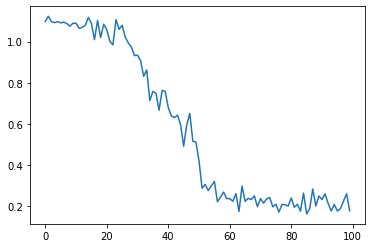

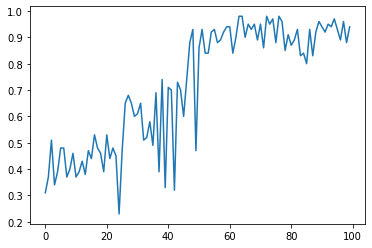

In [ ]:
########## Network specifications ########## 

loss_type = 'XE' # supports 'XE' or 'MSE'
n_hidden = 128
ro_bias = False
binary = False

########## Language specifications ########## 
phrase_length = 50
context_words = False

unordered_class = False

# Allows for variable phrase length, between min_phrase_len and phrase_len
variable_length = False 
min_phrase_len = 10

words = generateWordBank(context_words=context_words, variable_length=variable_length, unordered=unordered_class)
# sentiments = ['One', 'Two', 'Three', 'Four', 'Five']
sentiments = ['Bad', 'Neutral', 'Good']
# sentiments = ['Red', 'Green', 'Blue']

# Dictionary which holds all the specifications for generating training examples
example_specs = {'phrase_length': phrase_length, 'words': words, 'sentiments': sentiments, 'loss_type': loss_type, 
                 'variable_length': variable_length, 'min_phrase_len': min_phrase_len, 'unordered_class': unordered_class}

rnn = GruRNN(len(words), n_hidden, len(sentiments), ro_bias=ro_bias).to(device)

######### Training specifciations ########## 

n_iters = 10000
print_every = n_iters/20
plot_every = n_iters/100

test_trials = 100

# Training for 10,000 samples at 0.1 then going down to 0.01 for 10,000 seemed to work well for GRU at n_hidden = 128 with NO CONTEXT
# Training for 15,000 at 0.1, then 60,000 at 0.01 (here is where started to see some acc improvement), then 120,000 at 0.001 (very gradual decrease in loss)
learning_rate = 0.1
decay_iter = 5000
decay_lr = 0.01
l2_param = 0.0

optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, weight_decay=l2_param)

print('Using word bank:', words)
print('Using sentiments:', sentiments)
print('Binary output:', binary)

# Keep track of losses and accuracy for plotting
current_loss = 0
all_losses = []
all_accs = []

start = time.time()

lr = learning_rate

if loss_type == 'XE':
  criterion = nn.CrossEntropyLoss()
elif loss_type == 'MSE':
  criterion = nn.MSELoss()
else:
  raise ValueError('Loss not implemented!')

for iter in range(1, n_iters+1):
    # Generates a random training example and sends tensors to device
    sentiment, phrase, sentiment_tensor, phrase_tensor = randomTrainingExample(example_specs)
    sentiment_tensor = sentiment_tensor.to(device)
    phrase_tensor = phrase_tensor.to(device)

    output, loss = train(sentiment_tensor, phrase_tensor, rnn, optimizer, criterion)

    current_loss += loss
    if iter == decay_iter:
      adjust_learning_rate(optimizer, decay_lr)

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        test_acc = test_acc_rnn(test_trials, rnn, example_specs)
        all_losses.append(current_loss / plot_every)
        all_accs.append(test_acc)
        current_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        # Print iter number, loss, acc
        if iter % print_every == 0:
            print('%d %d%% (%s) %.8f / LR: %s / Acc: %s' % (iter, iter / n_iters * 100, timeSince(start),  loss, current_lr, test_acc))

trained_rnn = rnn

# Loss plot
plt.figure()
plt.plot(all_losses)
# Accuracy plot
plt.figure()
plt.plot(all_accs)

In [ ]:
# Saves a trained model
path = '/content/drive/My Drive/ml_research/nlp/gru_3class_rbg_wmodifiers_norobias.pth'
torch.save(trained_rnn.state_dict(), path)
print('Model Saved')

Model Saved


In [ ]:
# Loads a trained model
path = '/content/drive/My Drive/ml_research/nlp/gru_3class_rbg_norobias.pth'
loaded_rnn = GruRNN(len(words), n_hidden, len(sentiments), ro_bias=False).to(device)
loaded_rnn.load_state_dict(torch.load(path))

No readout bias.


<All keys matched successfully>

In [ ]:
rnn = loaded_rnn.to(device)

### Hidden State Analysis

In [ ]:
def evaluate_rnn_w_hidden(phrase, rnn):
    hidden = rnn.initHidden().to(device)
    hidden_vecs = np.zeros((phrase.size()[0], n_hidden))
    for i in range(phrase.size()[0]):
        output, hidden = rnn(phrase[i], hidden)
        # For Vanilla: grabs the last n_hidden values. Avoids part of hidden state that is inputs for VanillaRNN
        # hidden_vecs[i] = hidden.data.numpy()[0][-n_hidden:]
        # For GRU network
        hidden_vecs[i] = hidden.data.cpu().numpy()[0][0]
    return output, hidden_vecs

def collect_hidden_states(trials, trained_rnn, example_specs):
    print('Trained rnn has approx', test_acc_rnn(1000, trained_rnn, example_specs), 'test accuracy.')
    hidden_state_seqs = np.zeros((trials, phrase_length, n_hidden))
    phrases = []
    sentiments = []
    for i in range(trials):
      sentiment, phrase, sentiment_tensor, phrase_tensor = randomTrainingExample(example_specs)
      sentiment_tensor = sentiment_tensor.to(device)
      phrase_tensor = phrase_tensor.to(device)
      output, hidden_seq = evaluate_rnn_w_hidden(phrase_tensor, trained_rnn)
      hidden_state_seqs[i][:len(phrase)] = hidden_seq
      phrases.append(phrase)
      sentiments.append(sentiment)
    return hidden_state_seqs, sentiments, phrases

hidden_seq_n = 1000

hidden_seqs, hs_sentiments, hs_phrases = collect_hidden_states(hidden_seq_n, trained_rnn, example_specs)
hidden_seqs_flat = hidden_seqs.reshape(hidden_seq_n * phrase_length, n_hidden)

# For Vanilla
# readout = trained_rnn.i2o.weight.data[0][-n_hidden:].numpy()
# For GRU
if binary:
  readout = trained_rnn.o2o.weight.data[0].cpu().numpy()
else:
  readout = trained_rnn.o2o.weight.data.cpu().numpy()

Trained rnn has approx 0.848 test accuracy.


In [ ]:
readout_bias = trained_rnn.o2o.bias.data.cpu().numpy()
print(readout_bias)

AttributeError: ignored

Top 8 components: 0.9440461402621398 ( [0.41290418 0.13622495 0.12378299 0.09588261 0.07199353 0.04783467
 0.03580345 0.01961975] )
Shape of PC proj of hidden states: (1000, 50, 8)
Readout vec proj via PCA: [[ 0.03521187 -0.05974373  0.01129626]
 [-0.55439929  1.06524848 -0.44984404]
 [ 1.95952917 -0.97897564 -1.00106477]
 [-0.89744711 -2.13624816  3.06806382]
 [-2.30666464  2.12156706  0.27700801]
 [-0.85421116  0.92728361  0.00526512]
 [-1.34085493 -1.25271964  2.52074321]
 [-0.17982871 -0.73646669  0.78289716]]


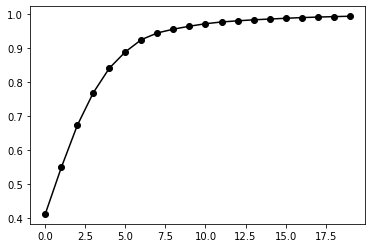

In [ ]:
# Standardizing the hidden states
hidden_seqs_flat_stand = StandardScaler().fit_transform(hidden_seqs_flat)
# hidden_seqs_flat_stand = hidden_seqs_flat

pc_dims = 8

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=n_hidden)
_ = pca_full.fit_transform(hidden_seqs_flat_stand)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
total_exvar = []
for i in range(n_hidden-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Performs pca on top components (this is redundant now)
pca = PCA(n_components=pc_dims)
principalComponents_flat = pca.fit_transform(hidden_seqs_flat_stand)
comp = pca.components_ # pc_dims x n_hidden
principalComponents = principalComponents_flat.reshape(hidden_seq_n, phrase_length, pc_dims)
print('Shape of PC proj of hidden states:', principalComponents.shape)
print('Readout vec proj via PCA:', np.matmul(comp, readout.T))

In [ ]:
# Test that PCA is working as expected
print(principalComponents[5][4])
test_hs = hidden_seqs_flat_stand.reshape(hidden_seq_n, phrase_length, n_hidden)
print(test_hs.shape)
print(np.matmul(comp, test_hs[5][4]))

[-4.65058083  9.17172806 -2.66373375 -3.03597727 -0.96644119  1.21866357
 -0.1160153  -0.15027422]
(100, 50, 128)
[-4.65058083  9.17172806 -2.66373375 -3.03597727 -0.96644119  1.21866357
 -0.1160153  -0.15027422]


['red', 'extremely', 'red', 'vblue', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'vgreen', 'extremely', 'blue', 'red', 'vblue', 'vred', 'vred', 'red', 'red', 'not', 'blue', 'extremely', 'vgreen', 'red', 'vgreen', 'not', 'blue', 'extremely', 'red', 'vred', 'vgreen', 'green', 'extremely', 'vgreen', 'red', 'red', 'vred', 'vgreen', 'not', 'vred', 'vred', 'blue', 'red', 'vred', 'vblue', 'vred', 'vred', 'red', 'blue', 'vblue']
0.0


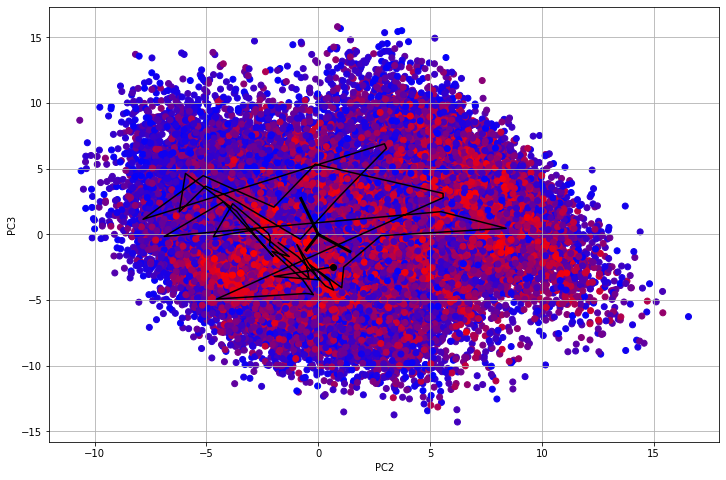

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pc1 = 1
pc2 = 2

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
# ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC' + str(pc1 + 1))
ax.set_ylabel('PC' + str(pc2 + 1))
# ax.set_zlabel('PC3')
for phrase_idx in range(hidden_seq_n):
  phrase_colors = []
  length_of_phrase = len(hs_phrases[phrase_idx])
  for word_idx in range(length_of_phrase):
    seq_color_norm = (length_of_phrase-word_idx)/length_of_phrase
    phrase_colors.append((seq_color_norm, 0, 1 - seq_color_norm))
  x_vals = [row[pc1] for row in principalComponents[phrase_idx]]
  y_vals = [row[pc2] for row in principalComponents[phrase_idx]]
  # z_vals = [row[2] for row in principalComponents[phrase_idx]]
  ax.scatter(x_vals[:length_of_phrase], y_vals[:length_of_phrase], c=phrase_colors)
  # ax.scatter(x_vals, y_vals, z_vals, c=phrase_colors)

ax.grid()

# Plots trajectory of a single chosen sample
single_samp = 55
x_vals = [row[pc1] for row in principalComponents[single_samp]]
y_vals = [row[pc2] for row in principalComponents[single_samp]]
ax.plot(x_vals, y_vals, 'k')
ax.plot(x_vals[0], y_vals[0], 'k-o') # Puts dot at start
print(hs_phrases[single_samp])
print(eval_toy_phrase(hs_phrases[single_samp]))

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  ro_mag = np.linalg.norm(ro_dir)
  x_ro = [0, 5/ro_mag * ro_dir[pc1]] # magnitude 5
  y_ro = [0, 5/ro_mag * ro_dir[pc2]]
  ax.plot(x_ro, y_ro, 'k', linewidth = 3)

['awful', 'good', 'awesome', 'the', 'bad', 'good', 'the', 'awful', 'awesome', 'good', 'good', 'the', 'bad', 'bad', 'awesome', 'awesome', 'the', 'awesome', 'bad', 'awesome', 'awful', 'bad', 'good', 'awful', 'bad', 'the', 'awful', 'awesome', 'the', 'bad', 'bad', 'good', 'awesome', 'awful', 'awful', 'awful', 'bad', 'awesome', 'awesome', 'good', 'the', 'awful', 'awful', 'bad', 'good', 'awesome', 'good', 'awful', 'the', 'good']
0.0


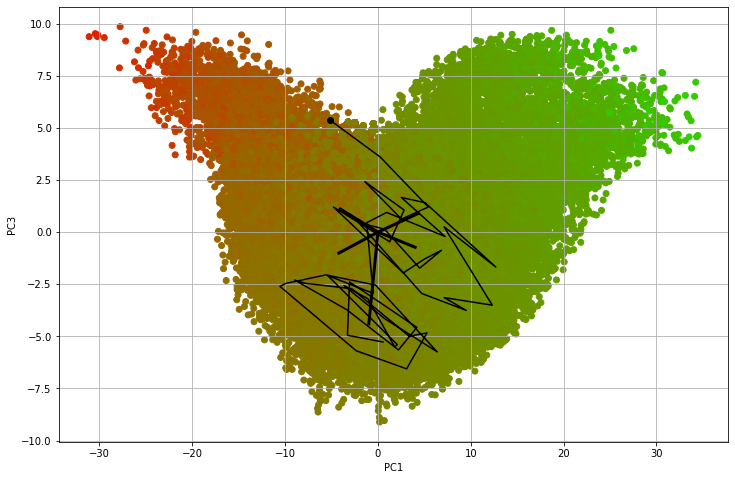

In [ ]:
# Plots by sentiment

pc1 = 0
pc2 = 2

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc1 + 1))
ax.set_ylabel('PC' + str(pc2 + 1))

max_sent = 5
min_sent = -5
sent_range = max_sent - min_sent

for phrase_idx in range(hidden_seq_n):
  phrase_colors = []
  for word_idx in range(phrase_length):
    total_sent = eval_toy_phrase(hs_phrases[phrase_idx][:word_idx+1])
    sent_score = (total_sent - min_sent) / sent_range
    phrase_colors.append((1 - sent_score, sent_score, 0))
  x_vals = [row[pc1] for row in principalComponents[phrase_idx]]
  y_vals = [row[pc2] for row in principalComponents[phrase_idx]]
  # z_vals = [row[2] for row in principalComponents[phrase_idx]]
  # ax.scatter(x_vals, y_vals, z_vals, c=seq_color)
  ax.scatter(x_vals, y_vals, c=phrase_colors)

ax.grid()

# Plots trajectory of a single chosen sample
single_samp = 33
x_vals = [row[pc1] for row in principalComponents[single_samp]]
y_vals = [row[pc2] for row in principalComponents[single_samp]]
ax.plot(x_vals, y_vals, 'k')
ax.plot(x_vals[0], y_vals[0], 'k-o') # Puts dot at start
print(hs_phrases[single_samp])
print(eval_toy_phrase(hs_phrases[single_samp]))

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  ro_mag = np.linalg.norm(ro_dir)
  x_ro = [0, 5/ro_mag * ro_dir[pc1]] # magnitude 5
  y_ro = [0, 5/ro_mag * ro_dir[pc2]]
  ax.plot(x_ro, y_ro, 'k', linewidth = 3)

['awful', 'awful', 'awful', 'the', 'awful', 'awesome', 'the', 'bad', 'bad', 'awful', 'good', 'the', 'the', 'awful', 'good', 'awesome', 'good', 'awesome', 'awful', 'the', 'the', 'the', 'the', 'bad', 'bad', 'awesome', 'awesome', 'bad', 'bad', 'good', 'good', 'good', 'bad', 'bad', 'awesome', 'awesome', 'awful', 'bad', 'good', 'bad', 'the', 'awful', 'awful', 'good', 'awful', 'good', 'good', 'awful', 'awful', 'bad']
-1.3


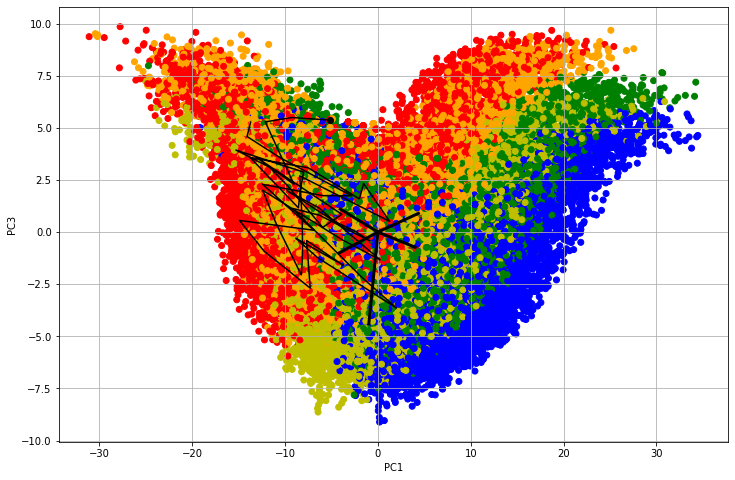

In [ ]:
# Plots by sentiment of word

pc1 = 0
pc2 = 2

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
# ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('PC' + str(pc1 + 1))
ax.set_ylabel('PC' + str(pc2 + 1))

# ax.set_zlabel('PC3')
for phrase_idx in range(hidden_seq_n):
  phrase_colors = []
  for word_idx in range(len(hs_phrases[phrase_idx])):
    if hs_phrases[phrase_idx][word_idx] == 'awesome':
      phrase_colors.append(('b'))
    elif hs_phrases[phrase_idx][word_idx] == 'good':
      phrase_colors.append('g')
    elif hs_phrases[phrase_idx][word_idx] == 'the':
      phrase_colors.append('y')
    elif hs_phrases[phrase_idx][word_idx] == 'bad':
      phrase_colors.append('orange')
    elif hs_phrases[phrase_idx][word_idx] == 'awful':
      phrase_colors.append('r')
    elif hs_phrases[phrase_idx][word_idx] == 'extremely':
      phrase_colors.append('purple')
    elif hs_phrases[phrase_idx][word_idx] == 'not':
      phrase_colors.append('c')
    elif hs_phrases[phrase_idx][word_idx] == '<EoS>':
      phrase_colors.append('k')
  x_vals = [row[pc1] for row in principalComponents[phrase_idx]]
  y_vals = [row[pc2] for row in principalComponents[phrase_idx]]
  # z_vals = [row[2] for row in principalComponents[phrase_idx]]
  ax.scatter(x_vals[:len(hs_phrases[phrase_idx])], y_vals[:len(hs_phrases[phrase_idx])], c=phrase_colors)
  # ax.scatter(x_vals, y_vals, z_vals, c=phrase_colors)

ax.grid()

# Plots trajectory of a single chosen sample
single_samp = 55
x_vals = [row[pc1] for row in principalComponents[single_samp]]
y_vals = [row[pc2] for row in principalComponents[single_samp]]
ax.plot(x_vals, y_vals, 'k')
ax.plot(x_vals[0], y_vals[0], 'k-o') # Puts dot at start
print(hs_phrases[single_samp])
print(eval_toy_phrase(hs_phrases[single_samp]))

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  ro_mag = np.linalg.norm(ro_dir)
  x_ro = [0, 5/ro_mag * ro_dir[pc1]] # magnitude 5
  y_ro = [0, 5/ro_mag * ro_dir[pc2]]
  ax.plot(x_ro, y_ro, 'k', linewidth = 3)

#### Readout Vector Analysis

In [ ]:
def subspace_perc(A, b):
  """
  A: an N x M matrix
  b: an N x 1 vector
  Finds the percentage of b's magnitude which lies in the subspace formed by the columns of A (its columnspace)
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T)
  b_proj = np.matmul(proj, b)

  return np.linalg.norm(b_proj)/np.linalg.norm(b)

A = np.array([a,b]).T

read_out_mags = []
for i in range(len(readout)):
  read_out_mags.append(np.linalg.norm(readout[i]))

for i in range(len(readout)):
  for j in range(i):
    print('Angle (', i, ',', j, '):', 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([readout[0], readout[1]]).T
A02 = np.array([readout[0], readout[2]]).T
A12 = np.array([readout[1], readout[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, readout[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, readout[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, readout[0]))

Angle ( 1 , 0 ): 115.25094548863768
Angle ( 2 , 0 ): 122.94143796574855
Angle ( 2 , 1 ): 121.22542123867456
Perc of 2 in (0,1): 0.99197584
Perc of 1 in (0,2): 0.9906737
Perc of 0 in (1,2): 0.99101985


Mag of x_dir: 1.0
Mag of y_dir: 1.0
Dot of axes: 0.0


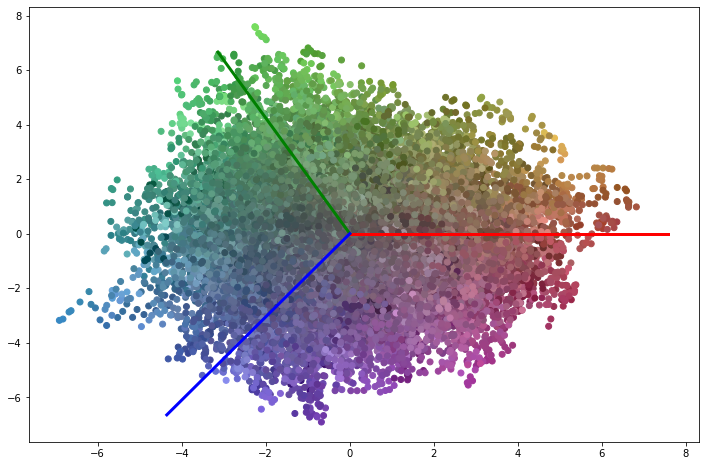

In [ ]:
# Project hidden states into readout vector space
ro1_idx = 0 # Takes this as x-direction of subspace
ro2_idx = 1 # Take this as other direction in subspace

ro_scale = 1.0 # Scales size of readouts if they're big

x_dir = readout[ro1_idx]/np.linalg.norm(readout[ro1_idx]) # Unit vector in x-direction
ro2_iy = readout[ro2_idx] - np.dot(x_dir, readout[ro2_idx]) * x_dir
y_dir = ro2_iy/np.linalg.norm(ro2_iy) # Unit vector in x-direction
print('Mag of x_dir:', np.linalg.norm(x_dir))
print('Mag of y_dir:', np.linalg.norm(x_dir))
print('Dot of axes:', np.dot(x_dir, y_dir))

hidden_seqs_flat_stand = StandardScaler().fit_transform(hidden_seqs_flat)
# A = np.array([readout[ro1_idx], readout[ro2_idx]]).T
# proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # n_hidden x n_hidden
hs_x_flat = np.matmul(hidden_seqs_flat_stand, x_dir) # hidden_seq_n * phrase_length x n_hidden
hs_y_flat = np.matmul(hidden_seqs_flat_stand, y_dir) # hidden_seq_n * phrase_length x n_hidden

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 

ax.scatter(hs_x_flat, hs_y_flat, c=phrase_colors)
ro_colors = ['r', 'g', 'b']
for i in range(len(readout)):
  ax.plot([0, ro_scale * np.dot(x_dir, readout[i])], [0, ro_scale*  np.dot(y_dir, readout[i])], c=ro_colors[i], linewidth = 3)


In [ ]:
for phrase_idx in range(hidden_seq_n):
  sents = []
  for word_idx in range(phrase_length):
    sents.append(eval_toy_phrase(hs_phrases[phrase_idx][:word_idx+1], unordered=True))

print(np.amax(sents.reshape(3*phrase_idx*word_idx)))
print(np.amin(sents.reshape(3*phrase_idx*word_idx)))

NameError: ignored

In [ ]:
max_sent = 4 # np.max(sents)
min_sent = -2 #np.min(sents)
sent_range = max_sent - min_sent

phrase_colors = []
for phrase_idx in range(hidden_seq_n):
  for word_idx in range(phrase_length):
    total_sent = eval_toy_phrase(hs_phrases[phrase_idx][:word_idx+1], unordered=True)
    sent_score = tuple([(sent - min_sent) / sent_range for sent in total_sent])
    phrase_colors.append(sent_score)

### Fixed Point Finder

#### Fixed Point Finder Functions

In [ ]:
def find_fixed_point(rnn, hidden_state):
  step_size = 0.1
  threshold = 10**-5
  steps = 0
  empty_input_tensor = torch.zeros(1, len(words)).to(device)
  # print('Original hidden', hidden_state.cpu().numpy())
  with torch.no_grad():
    output, next_hidden = rnn(empty_input_tensor, hidden_state)
  # print('Next hidden', next_hidden.cpu().numpy())
  # print('Hidden state:', hidden_state)
  # print('Next hidden:', next_hidden)
  grads = hidden_state - next_hidden
  # print('Grads', grads[0][0].cpu().numpy())
  residual = 1/n_hidden*np.dot(grads[0][0].cpu().numpy(), grads[0][0].cpu().numpy())
  
  while residual > threshold:
    # print('Residual hidden:', residual, '(Step ', steps, ')')
    # Attempts to minimize residual using gradient descent
    update_h = - 1 * step_size * grads
    hidden_state = hidden_state + update_h
    steps += 1
    # print('Updated hidden_State', hidden_state[0][0].cpu().numpy())
    with torch.no_grad():
      output, next_hidden = rnn(empty_input_tensor, hidden_state)
    
    # print('Updated next_hidden', next_hidden[0][0].cpu().numpy())
    grads = hidden_state - next_hidden
    # print('Updated grads', grads[0][0].cpu().numpy())
    residual = 1/n_hidden*np.dot(grads[0][0].cpu().numpy(), grads[0][0].cpu().numpy())

  # print('Fixed point found in', steps, 'steps. Residual:', residual)

  return hidden_state.view(1,-1), output

def find_many_fixed_points(rnn, trials, hidden_seqs_flat):
  fixed_points = []
  logits = []

  for i in range(trials):
    # Draws random hidden state from samples
    rand_idx = np.random.randint(hidden_seqs_flat.shape[0])
    # print('Index:', rand_idx)
    rand_hidden_state = torch.tensor(hidden_seqs_flat[rand_idx]).view(1,-1).float().to(device)
    # print('Random hidden state', rand_hidden_state)
    fixed_point, output_logit = find_fixed_point(rnn, rand_hidden_state)
    fixed_points.append(fixed_point.cpu())
    logits.append(output_logit.cpu())

  return fixed_points, logits

Fixed points found.


#### Finds Fixed Points

In [ ]:
fixed_points, logits = find_many_fixed_points(trained_rnn, 1000, hidden_seqs_flat)
print('Fixed points found.')

# Turns output logits into some measure of category
logits_np = []
for i in range(len(logits)):
  logits_np.append(logits[i].numpy()[0])

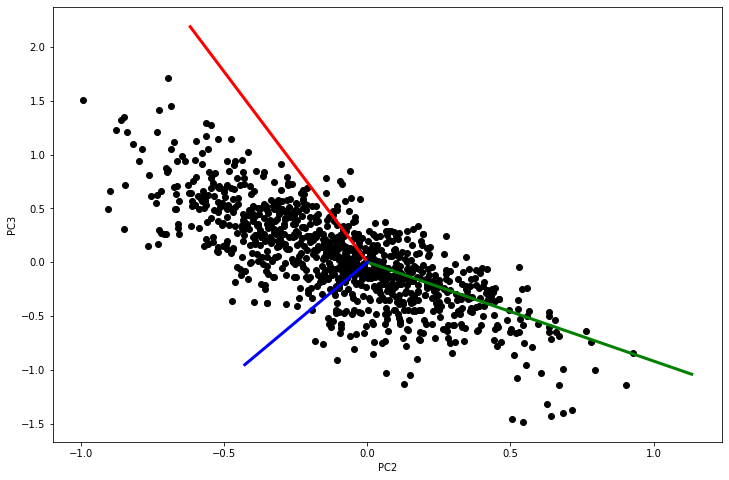

In [ ]:
# Plot fixed points and hidden state sentiments

plot_sentiments = False
pc1 = 1
pc2 = 2

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC' + str(pc1 + 1))
ax.set_ylabel('PC' + str(pc2 + 1))

if plot_sentiments:
  # Sentiments of hidden state space
  max_sent = 10
  min_sent = -10
  sent_range = max_sent - min_sent

  for phrase_idx in range(hidden_seq_n):
    phrase_colors = []
    for word_idx in range(phrase_length):
      total_sent = eval_toy_phrase(hs_phrases[phrase_idx][:word_idx+1])
      sent_score = (total_sent - min_sent) / sent_range
      phrase_colors.append((1 - sent_score, sent_score, 0.5))
    x_vals = [row[pc1] for row in principalComponents[phrase_idx]]
    y_vals = [row[pc2] for row in principalComponents[phrase_idx]]
    # z_vals = [row[2] for row in principalComponents[phrase_idx]]
    # ax.scatter(x_vals, y_vals, z_vals, c=seq_color)
    ax.scatter(x_vals, y_vals, c='k')

  ax.grid()

# Sentiments of fixed points
max_sent = np.max(logits_np)
min_sent = np.min(logits_np)
sent_range = max_sent - min_sent

x_vals = []
y_vals = []
fp_colors = []
for i in range(len(fixed_points)):
  sent_score = (logits_np[i] - min_sent) / sent_range
  # fp_colors.append((sent_score, 1 - sent_score, 0))\
  fp_colors.append(tuple(sent_score))
  fixed_point_proj = np.matmul(comp, fixed_points[i].numpy()[0])
  x_vals.append(fixed_point_proj[pc1])
  y_vals.append(fixed_point_proj[pc2])

# print('X_vals', x_vals)
# print('Y_vals', y_vals)
ax.scatter(x_vals, y_vals, c='k')
# ax.scatter(x_vals, y_vals, c=fp_colors)

# Plots readout direction
# Red and green
# ro_colors = [(173/255, 28/255, 28/255), (21/255, 115/255, 46/255)]
# Red, yellow, green
# ro_colors = [(173/255, 28/255, 28/255), (230/255, 204/255, 39/255), (21/255, 115/255, 46/255)]
# ro_colors = ['r', 'orange', 'y', 'g', 'b']
ro_colors = ['r', 'g', 'b']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  ro_mag = np.linalg.norm(ro_dir)
  x_ro = [0, 4/ro_mag * ro_dir[pc1]] # magnitude 5
  y_ro = [0, 4/ro_mag * ro_dir[pc2]]
  ax.plot(x_ro, y_ro, c = ro_colors[i], linewidth = 3)

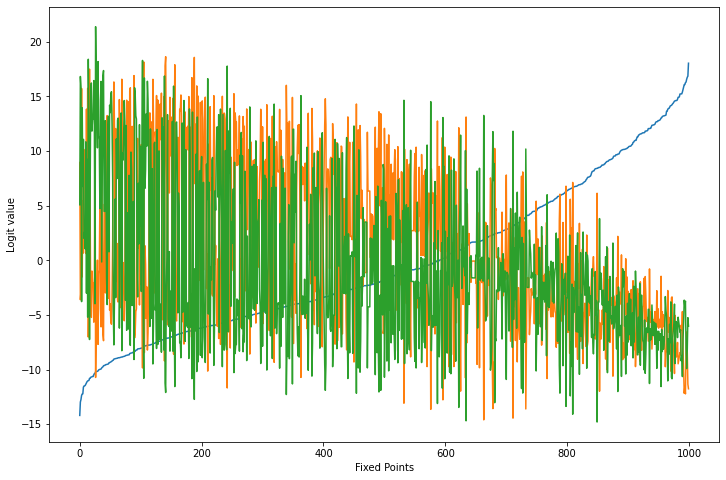

In [ ]:
# Plots logits, ordered by first

# Reorders logits_np so it is a list of elements
logit_vals = []
for i in range(len(sentiments)):
  logit_vals.append([row[i] for row in logits_np])

# Gets indices of list sorted by first logit
sorted_indices = sorted(range(len(logit_vals[0])), key=lambda k: logit_vals[0][k])

# Reorders according to indices above
sorted_logit_vals = []
for i in range(len(sentiments)):
  sorted_logit_vals.append([logit_vals[i][idx] for idx in sorted_indices])

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Fixed Points')
ax.set_ylabel('Logit value')

for i in range(len(sentiments)):
  ax.plot(sorted_logit_vals[i])
